# Final Project

## Task 1:

In [1]:
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import deque
import cv2

rgb_image = Image.open('./Dataset_25/Easy/images/000016.png').convert('RGB')
blurred_rgb_image = rgb_image.filter(ImageFilter.GaussianBlur(radius=2))
hsv_image = blurred_rgb_image.convert('HSV')
ground_truth_image = Image.open('./Dataset_25/Easy/masks/000016.png').convert('L')

bgr_image = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2BGR)

### Colour Thresholding: Hue Channel only

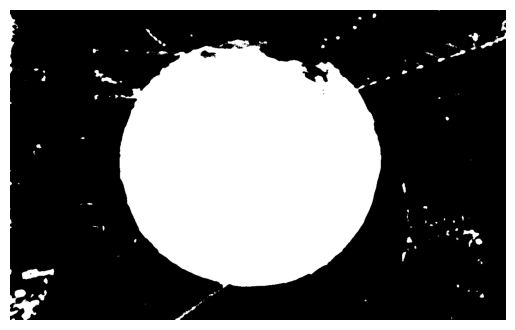

In [2]:
def threshoding(hsv_image: Image.Image, hue_threshold: list, saturation_threshold: int = 0) -> np.ndarray:
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)

    hue_channel = hsv_array[:, :, 0]
    saturation_channel = hsv_array[:, :, 1]
    mask = (hue_channel >= hue_threshold[0]) & (hue_channel <= hue_threshold[1]) & (saturation_channel >= saturation_threshold)
    binary_image = np.zeros_like(hue_channel)
    binary_image[mask] = 255

    return binary_image

threshoding_mask = threshoding(hsv_image=hsv_image, hue_threshold=[120, 360])
plt.imshow(threshoding_mask, cmap='gray')
plt.axis('off')
plt.show()

### Colour Thresholding: Hue + Saturation + Value

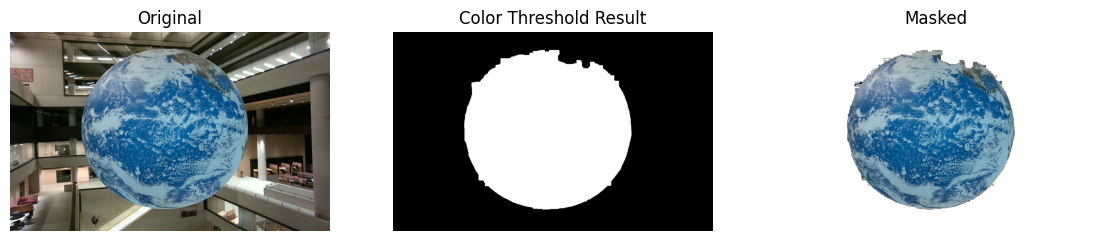

In [3]:
def crop_with_mask(img, mask, box):
    (x1, y1, x2, y2) = box

    # Crop image + crop mask
    cropped = img[y1:y2, x1:x2]
    mask_crop = mask[y1:y2, x1:x2]

    # White background outside the mask
    cropped_white = cropped.copy()
    cropped_white[mask_crop == 0] = [255, 255, 255]

    # Place back into white canvas
    canvas = np.ones_like(img) * 255
    canvas[y1:y2, x1:x2] = cropped_white

    return canvas

def color_threshold_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([55, 15, 40])
    upper_blue = np.array([150, 255, 210])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_white = np.array([90, 5, 180])
    upper_white = np.array([100, 15, 190])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    mask = cv2.bitwise_or(mask_blue, mask_white)

    kernel = np.ones((15, 15), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean, connectivity=4)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    earth_mask = (labels == largest_label).astype(np.uint8) * 255

    x, y, w, h, area = stats[largest_label]
    x1, y1 = x, y
    x2, y2 = x + w, y + h

    return earth_mask, (x1, y1, x2, y2)


cropped_mask, box = color_threshold_mask(bgr_image)
canvas = crop_with_mask(bgr_image, cropped_mask, box)


plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Color Threshold Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

### Region Growing

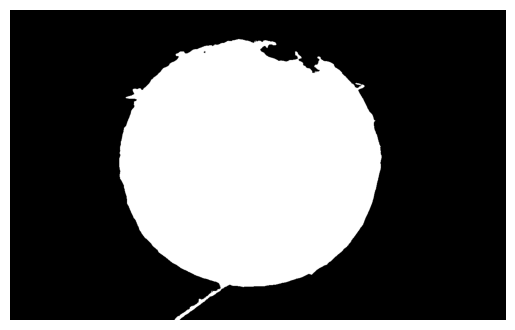

In [4]:
def region_growing(hsv_image: Image.Image, seed_point: tuple, threshold: int):
    # Setup
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)
    hue_channel = hsv_array[:, :, 0]

    if threshold == 0:
        return np.zeros_like(hue_channel)

    seeds = seed_point # Your ocean seed
    connectivity = 4 # or 8
    flags = connectivity | (255 << 8) | cv2.FLOODFILL_FIXED_RANGE
    
    # floodFill expects a numpy array. 
    # We work on the Hue channel directly.
    # Note: cv2.floodFill modifies the image in-place, so we copy.
    work_image = hue_channel.copy()
    
    h, w = work_image.shape
    mask = np.zeros((h+2, w+2), np.uint8) # floodFill requires mask to be 2px larger
    
    # Run Region Growing (Instant in C++)
    # For 1-channel image, newVal is a scalar, loDiff/upDiff are scalars.
    cv2.floodFill(work_image, mask, seeds, 255, (threshold,), (threshold,), flags)
    
    # Extract the actual binary map (Crop the 2px border)
    binary_output = mask[1:-1, 1:-1]

    return binary_output

region_growing_mask = region_growing(hsv_image=hsv_image, seed_point=(500, 500), threshold=50)
plt.imshow(region_growing_mask, cmap='gray')
plt.axis('off')
plt.show()

### Hough Circle Detection

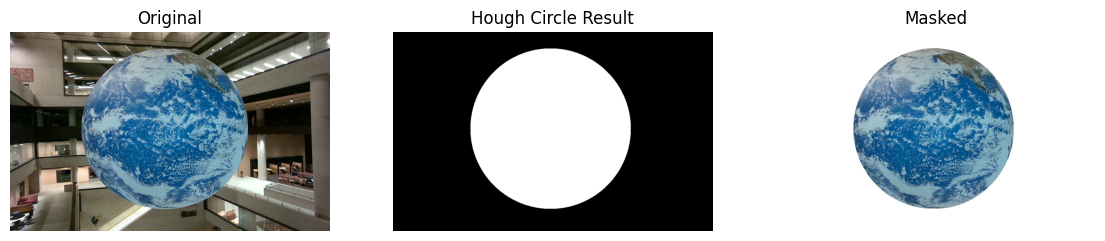

In [7]:
def hough_circle_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=50,
        param2=30,
        minRadius=300,
        maxRadius=400
    )

    # Create empty mask
    mask = np.zeros_like(gray)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]

        # Draw mask
        cv2.circle(mask, (x, y), r, 255, -1)

        # Bounding box
        x1 = max(x - r, 0)
        y1 = max(y - r, 0)
        x2 = min(x + r, img.shape[1])
        y2 = min(y + r, img.shape[0])

    else:
        # No circle found → return full white?
        mask[:] = 0
        x1, y1, x2, y2 = 0, 0, img.shape[1], img.shape[0]

    return mask, (x1, y1, x2, y2)


cropped_mask, box = hough_circle_mask(bgr_image)
canvas = crop_with_mask(bgr_image, cropped_mask, box)

plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Hough Circle Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

### Colour Thresholding + Region Growing

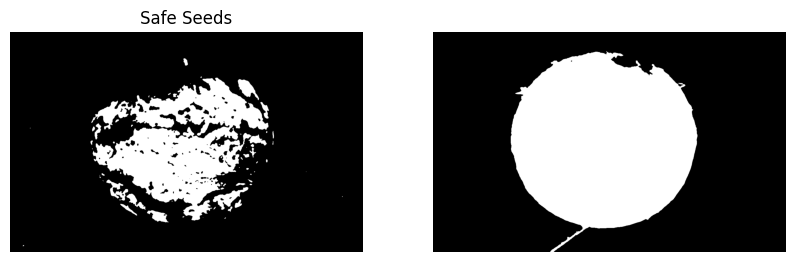

In [8]:
def threshold_and_region_growing(hsv_image: Image.Image, rg_threshold: int, saturation_threshold: int = 120):
    binary_seeds = threshoding(hsv_image, hue_threshold=[140, 190], saturation_threshold=saturation_threshold)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(binary_seeds, cmap='gray')
    plt.axis('off')
    plt.title('Safe Seeds')
    # plt.savefig('safe_ocean_seeds.png')


    segmented_images = []
    for y in range(0, binary_seeds.shape[0], 50):
        for x in range(0, binary_seeds.shape[1], 50):
            if binary_seeds[y, x] == 255:
                # print(f"Seed found at: ({x}, {y})")
                segmented_image = region_growing(hsv_image, seed_point=(x, y), threshold=rg_threshold)
                segmented_images.append(segmented_image)
    # Combine all segmented images
    combined_segmented_image = np.zeros_like(binary_seeds)
    for seg_img in segmented_images:
        combined_segmented_image = np.maximum(combined_segmented_image, seg_img)
    # plt.imshow(combined_segmented_image, cmap='gray')
    # plt.axis('off')
    # plt.show()

    return combined_segmented_image


mask = threshold_and_region_growing(hsv_image=hsv_image, rg_threshold=50, saturation_threshold=120)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

### ROC Curve

  0%|          | 0/21 [00:00<?, ?it/s]



TypeError: hough_circle_mask() got an unexpected keyword argument 'param2_threshold'

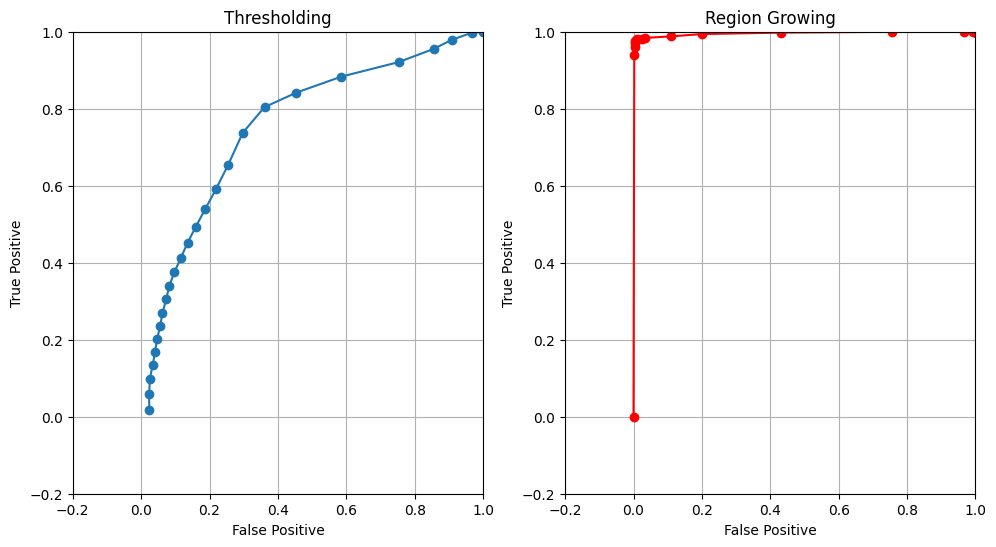

In [9]:
def draw_roc_curve(image: Image.Image, ground_truth_image: Image.Image, bgr_image):
    gt_array = np.array(ground_truth_image)
    blurred_image = image.copy().filter(ImageFilter.GaussianBlur(radius=2))
    hsv_img = blurred_image.convert("HSV")

    true_positive_thresholding = []
    true_negative_thresholding = []
    false_positive_thresholding = []
    false_negative_thresholding = []
    saturation_thresholds = range(0, 257, 10)

    for thresh in tqdm(saturation_thresholds):
        binary_image = threshoding(hsv_img, hue_threshold=[0, 255], saturation_threshold=thresh)
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        true_positive_thresholding.append(tp)
        false_positive_thresholding.append(fp)
        true_negative_thresholding.append(tn)
        false_negative_thresholding.append(fn)
    
    true_positive_rate_thresholding = np.array(true_positive_thresholding) / (np.array(true_positive_thresholding) + np.array(false_negative_thresholding) + 1e-6)
    false_positive_rate_thresholding = np.array(false_positive_thresholding) / (np.array(false_positive_thresholding) + np.array(true_negative_thresholding) + 1e-6)

    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)
    plt.plot(false_positive_rate_thresholding, true_positive_rate_thresholding, marker='o')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Thresholding')
    plt.xlim([-0.2, 1])
    plt.ylim([-0.2, 1])
    plt.grid()

    tp_region_growing = []
    tn_region_growing = []
    fp_region_growing = []
    fn_region_growing = []
    thresholds = range(0, 257, 10)
    seed_point = (500, 500)  # Example seed point
    blurred_image = image.copy().filter(ImageFilter.GaussianBlur(radius=2))
    hsv_img = blurred_image.convert("HSV")
    for thresh in tqdm(thresholds):
        binary_image = region_growing(hsv_img, seed_point=seed_point, threshold=thresh)
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        tp_region_growing.append(tp)
        fp_region_growing.append(fp)
        tn_region_growing.append(tn)
        fn_region_growing.append(fn)
    
    true_positive_rate_region_growing = np.array(tp_region_growing) / (np.array(tp_region_growing) + np.array(fn_region_growing) + 1e-6)
    false_positive_rate_region_growing = np.array(fp_region_growing) / (np.array(fp_region_growing) + np.array(tn_region_growing) + 1e-6)

    plt.subplot(1, 3, 2)
    plt.plot(false_positive_rate_region_growing, true_positive_rate_region_growing, marker='o', color='red')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Region Growing')
    plt.xlim([-0.2, 1])
    plt.ylim([-0.2, 1])
    plt.grid()



    tp_hough = []
    tn_hough = []
    fp_hough = []
    fn_hough = []

    # Vary param2 from high (strict) to low (loose)
    # Include 0 to force all-white mask
    hough_thresholds = list(range(100, 0, -5)) + [0]

    for thresh in tqdm(hough_thresholds):
        # We use the global bgr_image here as hough_circle_mask expects a BGR numpy array
        binary_image, _ = hough_circle_mask(bgr_image, param2_threshold=thresh)
        
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        
        tp_hough.append(tp)
        fp_hough.append(fp)
        tn_hough.append(tn)
        fn_hough.append(fn)

    true_positive_rate_hough = np.array(tp_hough) / (np.array(tp_hough) + np.array(fn_hough) + 1e-6)
    false_positive_rate_hough = np.array(fp_hough) / (np.array(fp_hough) + np.array(tn_hough) + 1e-6)

    plt.subplot(1, 3, 3)
    plt.plot(false_positive_rate_hough, true_positive_rate_hough, marker='o', color='green')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Hough Circle')
    plt.grid()
    plt.show()

    # # plotting all curves together
    # plt.plot(false_positive_rate_thresholding, true_positive_rate_thresholding, marker='.', color='blue', label='Thresholding')
    # plt.plot(false_positive_rate_region_growing, true_positive_rate_region_growing, marker='.', color='red', label='Region Growing')
    # plt.plot(false_positive_rate_hough, true_positive_rate_hough, marker='.', color='green', label='Hough Circle')
    # plt.xlabel('False Positive')
    # plt.ylabel('True Positive')
    # plt.title('ROC Curve Comparison')
    # plt.legend()
    # plt.grid()
    # plt.show()

draw_roc_curve(rgb_image, ground_truth_image, bgr_image)